### Step 0: Import Libraries and Functions

In [3]:
# Standard libraries
import sys
import os
import math
import random
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
# Going to make sure we can load all the custom scripts from the directory
scripts_dir = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\scripts\analysis"
# Add scripts directory to sys.path
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

from model_dependence import model_dependence
from analysis_functions import simple_risk_overlay
from analysis_functions import basin_loss_curve, interpolate_damages, get_copula_model, generate_conditional_sample
from analysis_functions import sectoral_monte_carlo_dependence_simulation, sectoral_urban_monte_carlo_dependence_simulation, run_DIGNAD
from analysis_functions import dignad_loss_probability, get_loss_for_rp, get_dignad_inputs_for_rp
from D_analysis_info import zonal_sum_rasters_info_uncertainty

### Step 1: Define Hazard, Exposure, and Vulnerability Data

#### 1.1 Hazard

In [4]:
flood_map_nested_dictionary = {'GIRI':{2: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h2glob.tif",
                                          5: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h5glob.tif",
                                          10: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h10glob.tif",
                                          25: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h25glob.tif",
                                          50: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h50glob.tif",
                                          100: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h100glob.tif",
                                          200: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h200glob.tif",
                                          500: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h500glob.tif",
                                          1000: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\GIRI_m\THA_global_pc_h1000glob.tif"},
                               'JRC':{10: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\JRC\THA_global_10.tif",
                                          20: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\JRC\THA_global_20.tif",
                                          50: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\JRC\THA_global_50.tif",
                                          100: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\JRC\THA_global_100.tif",
                                          200: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\JRC\THA_global_200.tif",
                                          500: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\JRC\THA_global_500.tif"},
                              'WRI':{5: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\WRI\wri_historical_5.tif",
                                    10: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\WRI\wri_historical_10.tif",
                                    25: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\WRI\wri_historical_25.tif",
                                    50: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\WRI\wri_historical_50.tif",
                                    100: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\WRI\wri_historical_100.tif",
                                    250: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\WRI\wri_historical_250.tif",
                                    500: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\WRI\wri_historical_500.tif",
                                    1000: r"D:\projects\sovereign-risk\Thailand\data\flood\maps\WRI\wri_historical_1000.tif"}
                              }

#### 1.2 Exposure

In [5]:
res_exposure_path = r"D:\projects\sovereign-risk\Thailand\data\exposure\DIGNAD\res_cap_stock_thb.tif"
com_exposure_path = r"D:\projects\sovereign-risk\Thailand\data\exposure\DIGNAD\com_cap_stock_thb.tif"
ind_exposure_path = r"D:\projects\sovereign-risk\Thailand\data\exposure\DIGNAD\ind_cap_stock_thb.tif"
inf_exposure_path = r"D:\projects\sovereign-risk\Thailand\data\exposure\DIGNAD\inf_cap_stock_thb.tif"

#### 1.3 Vulnerability

In [6]:
# Vulnerability
jrc_depth_damage = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\data\flood\vulnerability\jrc_depth_damage.csv"
# Extract vulnerability information
vuln_df = pd.read_csv(jrc_depth_damage)
v_heights = vuln_df['flood_depth'].to_list()
v_dp_heights = vuln_df['flood_depth_dryproof'].to_list() # dryproof functions
v_res = vuln_df['asia_residential'].to_list()
v_res_sd = vuln_df['asia_residential_sd'].to_list()
v_res_dp = vuln_df['asia_residential_dryproof'].to_list()
v_res_dp_sd = vuln_df['asia_residential_dryproof_sd'].to_list()
v_com = vuln_df['asia_commercial'].to_list()
v_com_sd = vuln_df['asia_commercial_sd'].to_list()
v_com_dp = vuln_df['asia_commercial_dryproof'].to_list()
v_com_dp_sd = vuln_df['asia_commercial_dryproof_sd'].to_list()
v_ind = vuln_df['asia_industrial'].to_list()
v_ind_sd = vuln_df['asia_industrial_sd'].to_list()
v_ind_dp = vuln_df['asia_industrial_dryproof'].to_list()
v_ind_dp_sd = vuln_df['asia_industrial_dryproof_sd'].to_list()
v_inf = vuln_df['asia_infrastructure'].to_list()
v_inf_sd = vuln_df['asia_infrastructure_sd'].to_list()

### Step 2: Run Risk Overlay

In [7]:
## Begin by calculating damages under baseline adaptation scenario (no adaptation)
baseline_results_dir = r"D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty"
if not os.path.exists(baseline_results_dir):
    os.makedirs(baseline_results_dir)
    print('Baseline directory does not exist...creating')

print('Working on Baseline Risk Maps')

for model in flood_map_nested_dictionary:
    for RP in flood_map_nested_dictionary[model]:
        res_output_path = os.path.join(baseline_results_dir, '%s_%s_res_damages.tif') % (model, RP)
        com_output_path = os.path.join(baseline_results_dir, '%s_%s_com_damages.tif') % (model, RP)
        ind_output_path = os.path.join(baseline_results_dir, '%s_%s_ind_damages.tif') % (model, RP)
        inf_output_path = os.path.join(baseline_results_dir, '%s_%s_inf_damages.tif') % (model, RP)
        res_sd_output_path = os.path.join(baseline_results_dir, '%s_%s_res_damages_sd.tif') % (model, RP)
        com_sd_output_path = os.path.join(baseline_results_dir, '%s_%s_com_damages_sd.tif') % (model, RP)
        ind_sd_output_path = os.path.join(baseline_results_dir, '%s_%s_ind_damages_sd.tif') % (model, RP)
        inf_sd_output_path = os.path.join(baseline_results_dir, '%s_%s_inf_damages_sd.tif') % (model, RP)
        # Skip if files already exist
        if os.path.exists(res_output_path) and os.path.exists(com_output_path) and os.path.exists(ind_output_path) and os.path.exists(inf_output_path):
            print('Dataset already exists: skipping...', res_output_path, com_output_path, ind_output_path, inf_output_path) 
            continue
        else:
            flood_path = flood_map_nested_dictionary[model][RP]
            print('Working on: ', flood_path)
            simple_risk_overlay(flood_path, res_exposure_path, res_output_path, [v_heights, v_res], 1)
            simple_risk_overlay(flood_path, com_exposure_path, com_output_path, [v_heights, v_com], 1)
            simple_risk_overlay(flood_path, ind_exposure_path, ind_output_path, [v_heights, v_ind], 1)
            simple_risk_overlay(flood_path, inf_exposure_path, inf_output_path, [v_heights, v_inf], 1)
            simple_risk_overlay(flood_path, res_exposure_path, res_sd_output_path, [v_heights, v_res_sd], 1)
            simple_risk_overlay(flood_path, com_exposure_path, com_sd_output_path, [v_heights, v_com_sd], 1)
            simple_risk_overlay(flood_path, ind_exposure_path, ind_sd_output_path, [v_heights, v_ind_sd], 1)
            simple_risk_overlay(flood_path, inf_exposure_path, inf_sd_output_path, [v_heights, v_inf_sd], 1)

Working on Baseline Risk Maps
Dataset already exists: skipping... D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_2_res_damages.tif D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_2_com_damages.tif D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_2_ind_damages.tif D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_2_inf_damages.tif
Dataset already exists: skipping... D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_5_res_damages.tif D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_5_com_damages.tif D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_5_ind_damages.tif D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_5_inf_damages.tif
Dataset already exists: skipping... D:\projects\sovereign-risk\Thailand\analysis\flood\risk_maps\uncertainty\GIRI_10_res_damages.t

### Step 3: Flood Risk Zonal Sum

#### 3.1 Set paths and initialize analysis

In [24]:
# Set basin path
basin_path = r"D:\projects\sovereign-risk\Thailand\data\flood\basins\analysis_basins.gpkg"
# Set output path
output_path = r"D:\projects\sovereign-risk\Thailand\analysis\flood\risk_analysis\uncertainty\risk_basin_zonal_sum.csv"
# Load basins
basin_df = gpd.read_file(basin_path)
# Initialize an empty DataFrame to store zonal statistics from all rasters
results_df = pd.DataFrame()

#### 3.2 Run the zonal sum

In [25]:
i = 0
# Loop through all rasters. Calculating zonal sum for each
for raster_info in zonal_sum_rasters_info_uncertainty:
    
    # Print Progress
    if i % 20 == 0:
        print('Layer #', i)
        print(raster_info)
    i += 1

    # Calculate zonal statistics for each raster
    zs = zonal_stats(basin_df, raster_info['file'], stats="sum", geojson_out=True)

    # Prepare a DataFrame from the zonal statistics. Store all the necessary column info from the original GeoDataFrame
    temp_df = pd.DataFrame({
        "FID": [feat['id'] for feat in zs],
        "GID_1": [feat['properties']['flpr_gid_1'] for feat in zs],
        "NAME": [feat['properties']['NAME'] for feat in zs],
        "HB_L4": [feat['properties']['HYBAS_ID_04'] for feat in zs],
        "HB_L5": [feat['properties']['HYBAS_ID_05'] for feat in zs],
        "HB_L6": [feat['properties']['HYBAS_ID_06'] for feat in zs],
        "HB_L7": [feat['properties']['HYBAS_ID_07'] for feat in zs],
        "Pr_L": [feat['properties']['MerL_Riv'] for feat in zs],
        "Add_Pr": [feat['properties']['Add_Pr'] for feat in zs],
        "New_Pr_L": [feat['properties']['New_Pr_L'] for feat in zs],
        "damages": [feat['properties']['sum'] for feat in zs]
    })

    # Add raster information to the DataFrame
    temp_df["model"] = raster_info['model']
    temp_df["adaptation_scenario"] = raster_info['adaptation_scenario']
    temp_df["RP"] = raster_info['RP']
    temp_df["urban_class"] = raster_info['urban_class']
    temp_df["statistic"] = raster_info['statistic']

    # Remove NaNs from damage column
    temp_df['damages'] = temp_df['damages'].fillna(0)

    # Concatenate the temporary DataFrame with the results DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Save results
results_df.to_csv(output_path)

Layer # 0
{'model': 'GIRI', 'adaptation_scenario': 'Baseline', 'RP': 2, 'urban_class': 'Residential', 'statistic': 'mean', 'file': 'D:\\projects\\sovereign-risk\\Thailand\\analysis\\flood\\risk_maps\\uncertainty\\GIRI_2_res_damages.tif'}
Layer # 20
{'model': 'GIRI', 'adaptation_scenario': 'Baseline', 'RP': 10, 'urban_class': 'Commercial', 'statistic': 'mean', 'file': 'D:\\projects\\sovereign-risk\\Thailand\\analysis\\flood\\risk_maps\\uncertainty\\GIRI_10_com_damages.tif'}
Layer # 40
{'model': 'GIRI', 'adaptation_scenario': 'Baseline', 'RP': 50, 'urban_class': 'Industrial', 'statistic': 'mean', 'file': 'D:\\projects\\sovereign-risk\\Thailand\\analysis\\flood\\risk_maps\\uncertainty\\GIRI_50_ind_damages.tif'}
Layer # 60
{'model': 'GIRI', 'adaptation_scenario': 'Baseline', 'RP': 200, 'urban_class': 'Infrastructure', 'statistic': 'mean', 'file': 'D:\\projects\\sovereign-risk\\Thailand\\analysis\\flood\\risk_maps\\uncertainty\\GIRI_200_inf_damages.tif'}
Layer # 80
{'model': 'JRC', 'adaptat

### Step 4: Monte Carlo Aggregation

#### 4.1 Set up copula dependency model

In [10]:
clayton_copula_models, ordered_basins = model_dependence()

#### 4.2 Load basin-level risk data

In [11]:
risk_data_file = r"D:\projects\sovereign-risk\Thailand\analysis\flood\risk_analysis\uncertainty\risk_basin_zonal_sum.csv"
risk_data = pd.read_csv(risk_data_file)
# Add columne for annual exceedance probability
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
# Add entries converting SD to variance (this will help for summation)
sd_rows = risk_data[risk_data['statistic']=='sd']
variance_rows = sd_rows.copy() # create new rows for variance
variance_rows['statistic'] = 'variance'
variance_rows['damages'] = variance_rows['damages'] ** 2
risk_data = pd.concat([risk_data, variance_rows], ignore_index=True)
# Add row for each combination that sums residential and non-residential damages
grouped = risk_data.groupby(['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'model', 'adaptation_scenario', 'RP', 'AEP', 'statistic'], as_index=False)['damages'].sum()
grouped['urban_class'] = 'Combined'  # Add a column for urban_class with value 'total'
risk_data = pd.concat([risk_data, grouped], ignore_index=True).sort_values(by=['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'model', 'adaptation_scenario', 'RP', 'AEP', 'statistic'])
risk_data.reset_index(drop=True, inplace=True)
# Add epoch column (debug need to add this to risk overlay)
risk_data['epoch'] = 'Today'


#### 4.3 Run simulation

In [63]:
# Temp
def basin_loss_curve_u(loss_df, basin_id, basin_col, model_val, epoch_val, scenario_val, statistic_val, urban_class, rps):
    '''
    Function for extracting loss curves from each basin from the risk results dataframe.
    Extracting these loss curves at the beginning of the Monte Carlo simulation significantly reduces 
    compuatation times. 
    '''
    losses = {} # initialize empty dictionary to store losses and protection level
    basin_df = loss_df[(loss_df[basin_col]==basin_id) & (loss_df['model']==model_val) & (loss_df['epoch']==epoch_val) & (loss_df['adaptation_scenario']==scenario_val) & (loss_df['statistic']==statistic_val) & (loss_df['urban_class']==urban_class)]
    grouped_basin_df = basin_df.groupby([basin_col, 'RP', 'Pr_L_AEP']).agg({'damages':'sum'}).reset_index()
    # # Pull unique protection levels from the grouped dataframe
    unique_protection_levels = grouped_basin_df['Pr_L_AEP'].unique()
    if len(unique_protection_levels) == 0:
        unique_protection_levels = [1]
    for i in unique_protection_levels:
        losses[i] = [grouped_basin_df.loc[(grouped_basin_df['RP'] == rp) & (grouped_basin_df['Pr_L_AEP']==i), 'damages'].sum() for rp in rps]

    return losses

def interpolate_damages(RPs, losses, sim_aep, protection_level=0.5):
    '''
    Function to interpolate damages between given an annual exceedance probability and 
    a depth-damage curve
    '''
    aeps = [1/i for i in RPs]
    # Ensure AEPs are in ascending order for np.interp
    aeps.sort() 
    losses = losses[::-1]

    # Interpolate based off simulated AEP
    if sim_aep >= protection_level: 
        return 0 
    else:
        interpolated_value = np.interp(sim_aep, aeps, losses)
        return interpolated_value

# def loss_simulation_uncertainty(basin_id, random_number, loss_curves, model_rps):
#     # Going to randomly select a model
#     random_model = random.choice(list(model_rps.keys()))
#     rps = model_rps[random_model]
#     basin_losses = 0 # will add to this and return at end

#     mean_loss_curves = loss_curves[random_model]['mean'][basin_id]
#     sd_loss_curves = loss_curves[random_model]['std_dev'][basin_id] 

#     for Pr_L in mean_loss_curves:
#         if Pr_L < random_number: # check is random number greater than protection level?
#             continue
#         else:
#             # Temporary fix (need to update so it's not hardcoded)
#             if random_model != 'GIRI':
#                 # Need to add 2 year return period for models that don't have that
#                 adjusted_rps = [2] + rps 
#                 adjusted_mean_loss_curve = [0] + mean_loss_curves[Pr_L]
#                 adjusted_sd_loss_curve = [0] + sd_loss_curves[Pr_L]
#                 mean_damage = interpolate_damages(adjusted_rps, adjusted_mean_loss_curve, random_number)
#                 sd_damage = interpolate_damages(adjusted_rps, adjusted_sd_loss_curve, random_number)
#             else:
#                 mean_damage = interpolate_damages(rps, mean_loss_curves[Pr_L], random_number)
#                 sd_damage = interpolate_damages(rps, sd_loss_curves[Pr_L], random_number)

#             # Sample from the normal distribution of losses
#             sampled_damage = max(0, random.gauss(mean_damage, sd_damage)) # ensuring no negative values

#         basin_losses += sampled_damage

#     return basin_losses
    
# def monte_carlo_dependence_simulation_u(loss_df, flood_model, basin_col, epoch_val, scenario_val, urban_class, protection_level, num_years, ordered_basins, copula_models, num_simulations=10000):
#     '''
#     Perform Monte Carlo simulations of yearly losses incorporating basin dependencies.

#     :param loss_df: dataframe with losses from risk analysis
#     :param basin_col: name of column for basins (e.g. 'HB_L6')
#     :param epoch_val: name of epoch value (e.g. 'Today')
#     :param scenario_val: name of scenario (e.g. 'Baseline')
#     :param urban_class: name of urban class to consider (e.g. 'Residential')
#     :param protection_level: what is the baseline protection level (e.g. 0.5 or 1 in 2 years)
#     :param num_years: Number of years to simulate
#     :param ordered_basins: List of basin IDs ordered by dependency
#     :param copula_models: Dictionary holding copula model for each basin pair
#     :param num_simulations: Number of simulations (default is 10,000).
#     :return: Dataframe of simulated national losses for each year.
#     '''

#     model_rps = {'GIRI': [2, 5, 10, 25, 50, 100, 200, 500, 1000],
#                 'JRC': [10, 20, 50, 100, 200, 500],
#                 'WRI': [5, 10, 25, 50, 100, 250, 500, 1000]}

#     if flood_model != "all":
#         temp_model = {}
#         temp_model[flood_model] = model_rps[flood_model]
#         model_rps = temp_model        
    
#     # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
#     # precompute loss-probability curves for each basin
#     basin_loss_curves = {}

#     for model in model_rps:
#         basin_loss_curves[model] = {}
#         basin_loss_curves[model]['mean'] = {basin_id: basin_loss_curve_u(loss_df, basin_id, basin_col, model, epoch_val, scenario_val, 'mean', urban_class, model_rps[model]) for basin_id in ordered_basins}
#         basin_loss_curves[model]['variance'] = {basin_id: basin_loss_curve_u(loss_df, basin_id, basin_col, model, epoch_val, scenario_val, 'variance', urban_class, model_rps[model]) for basin_id in ordered_basins}

#     # Add standard deviation based on variance
#     for category, values in basin_loss_curves.items():
#         std_dev = {}
#         for id_key, nested_dict in values['variance'].items():
#             std_dev[id_key] = {}
#             for inner_key, variance_list in nested_dict.items():
#                 std_dev[id_key][inner_key] = [math.sqrt(x) for x in variance_list]
#         basin_loss_curves[category]['std_dev'] = std_dev
    
#     # basin_loss_curves = {basin_id: basin_loss_curve_u(loss_df, basin_id, basin_col, 'GIRI', epoch_val, scenario_val, 'variance', urban_class, rps) for basin_id in ordered_basins}
#     # print(basin_loss_curves)
#     # Initialize array for national losses
#     national_losses_per_year = np.zeros((num_simulations, num_years))
#     # Generate all random numbers in advance
#     random_numbers = np.random.uniform(0, 1, (num_simulations, num_years, len(ordered_basins))).astype(np.float32)

#     for simulation in range(num_simulations):
#         # # print progress
#         # if simulation % 50 == 0:
#         #     print('Simulation progress: %s out of %s' % (simulation, num_simulations))
#         for year in range(num_years):
#             # Initialize a list to store losses for each basin for the current year
#             yearly_losses = []
#             yearly_loss_values = []
#             for i, basin_id in enumerate(ordered_basins):
#                 # print(basin_id)
#                 if i == 0:
#                     # Handle first basin
#                     r = random_numbers[simulation, year, i]
#                     yearly_losses.append(r) # add current loss simulation to the list
#                     yearly_loss_values.append(loss_simulation_uncertainty(basin_id, r, basin_loss_curves, model_rps))
#                 else:
#                     # Handle subsequent basins with dependencies
#                     copula = get_copula_model(copula_models, ordered_basins[i-1], basin_id)
#                     if copula is not None:
#                         # Apply dependency model if theta exists
#                         r = random_numbers[simulation, year, i]
#                         previous_loss = yearly_losses[i-1]
#                         current_loss = generate_conditional_sample(previous_loss, copula.theta, r)
#                         yearly_losses.append(current_loss)
#                         yearly_loss_values.append(loss_simulation_uncertainty(basin_id, current_loss, basin_loss_curves, model_rps))
#                     else:
#                         # Independent simulation for this basin
#                         r = random_numbers[simulation, year, i]
#                         yearly_losses.append(r)
#                         yearly_loss_values.append(loss_simulation_uncertainty(basin_id, r, basin_loss_curves, model_rps))
                        
#             # Aggregate losses for the current year
#             national_losses_per_year[simulation, year] = sum(yearly_loss_values)

#     # Convert the results into a DataFrame
#     return pd.DataFrame(national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

# Attempt 2
def loss_simulation_uncertainty(basin_id, random_lp_number, random_number, loss_curves, model_rps):
    # Going to randomly select a model
    random_model = random.choice(list(model_rps.keys()))
    rps = model_rps[random_model]
    basin_losses = 0 # will add to this and return at end

    mean_loss_curves = loss_curves[random_model]['mean'][basin_id]
    sd_loss_curves = loss_curves[random_model]['std_dev'][basin_id] 

    for Pr_L in mean_loss_curves:
        if Pr_L < random_number: # check is random number greater than protection level?
            continue
        else:
            # Temporary fix (need to update so it's not hardcoded)
            if random_model != 'GIRI':
                # Need to add 2 year return period for models that don't have that
                adjusted_rps = [2] + rps 
                adjusted_mean_loss_curve = [0] + mean_loss_curves[Pr_L]
                adjusted_sd_loss_curve = [0] + sd_loss_curves[Pr_L]
                mean_damage = interpolate_damages(adjusted_rps, adjusted_mean_loss_curve, random_number)
                sd_damage = interpolate_damages(adjusted_rps, adjusted_sd_loss_curve, random_number)
            else:
                mean_damage = interpolate_damages(rps, mean_loss_curves[Pr_L], random_number)
                sd_damage = interpolate_damages(rps, sd_loss_curves[Pr_L], random_number)

            # Sample from the normal distribution of losses
            sampled_damage = max(0, mean_damage + (random_lp_number * sd_damage)) # ensuring no negative values

        basin_losses += sampled_damage

    return basin_losses

def monte_carlo_dependence_simulation_u(loss_df, basin_col, epoch_val, scenario_val, urban_class, protection_level, num_years, ordered_basins, copula_models, num_simulations=10000):
    '''
    Perform Monte Carlo simulations of yearly losses incorporating basin dependencies.

    :param loss_df: dataframe with losses from risk analysis
    :param basin_col: name of column for basins (e.g. 'HB_L6')
    :param epoch_val: name of epoch value (e.g. 'Today')
    :param scenario_val: name of scenario (e.g. 'Baseline')
    :param urban_class: name of urban class to consider (e.g. 'Residential')
    :param protection_level: what is the baseline protection level (e.g. 0.5 or 1 in 2 years)
    :param num_years: Number of years to simulate
    :param ordered_basins: List of basin IDs ordered by dependency
    :param copula_models: Dictionary holding copula model for each basin pair
    :param num_simulations: Number of simulations (default is 10,000).
    :return: Dataframe of simulated national losses for each year.
    '''

    model_name_and_rps = {'GIRI': [2, 5, 10, 25, 50, 100, 200, 500, 1000],
                            'JRC': [10, 20, 50, 100, 200, 500],
                            'WRI': [5, 10, 25, 50, 100, 250, 500, 1000]}   
    
    # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
    # precompute loss-probability curves for each basin
    basin_loss_curves = {}

    for model in model_name_and_rps:
        basin_loss_curves[model] = {}
        basin_loss_curves[model]['mean'] = {basin_id: basin_loss_curve_u(loss_df, basin_id, basin_col, model, epoch_val, scenario_val, 'mean', urban_class, model_name_and_rps[model]) for basin_id in ordered_basins}
        basin_loss_curves[model]['variance'] = {basin_id: basin_loss_curve_u(loss_df, basin_id, basin_col, model, epoch_val, scenario_val, 'variance', urban_class, model_name_and_rps[model]) for basin_id in ordered_basins}

    # Add standard deviation based on variance
    for category, values in basin_loss_curves.items():
        std_dev = {}
        for id_key, nested_dict in values['variance'].items():
            std_dev[id_key] = {}
            for inner_key, variance_list in nested_dict.items():
                std_dev[id_key][inner_key] = [math.sqrt(x) for x in variance_list]
        basin_loss_curves[category]['std_dev'] = std_dev
    
    # basin_loss_curves = {basin_id: basin_loss_curve_u(loss_df, basin_id, basin_col, 'GIRI', epoch_val, scenario_val, 'variance', urban_class, rps) for basin_id in ordered_basins}
    # print(basin_loss_curves)
    # Initialize array for national losses
    national_losses_per_year = np.zeros((num_simulations, num_years))
    # Generate all random numbers in advance
    random_numbers = np.random.uniform(0, 1, (num_simulations, num_years, len(ordered_basins))).astype(np.float32)

    for simulation in range(num_simulations):
        # Choose a random model
        model_rps = {}
        flood_model = random.choice(list(model_name_and_rps.keys()))
        model_rps[flood_model] = model_name_and_rps[flood_model]
        # Choose random number for sampling from loss-probability curve
        random_lp_number = np.random.normal(loc=0, scale=1)
        
        # # print progress
        # if simulation % 50 == 0:
        #     print('Simulation progress: %s out of %s' % (simulation, num_simulations))
        for year in range(num_years):
            # Initialize a list to store losses for each basin for the current year
            yearly_losses = []
            yearly_loss_values = []
            for i, basin_id in enumerate(ordered_basins):
                # print(basin_id)
                if i == 0:
                    # Handle first basin
                    r = random_numbers[simulation, year, i]
                    yearly_losses.append(r) # add current loss simulation to the list
                    yearly_loss_values.append(loss_simulation_uncertainty(basin_id, random_lp_number, r, basin_loss_curves, model_rps))
                else:
                    # Handle subsequent basins with dependencies
                    copula = get_copula_model(copula_models, ordered_basins[i-1], basin_id)
                    if copula is not None:
                        # Apply dependency model if theta exists
                        r = random_numbers[simulation, year, i]
                        previous_loss = yearly_losses[i-1]
                        current_loss = generate_conditional_sample(previous_loss, copula.theta, r)
                        yearly_losses.append(current_loss)
                        yearly_loss_values.append(loss_simulation_uncertainty(basin_id, random_lp_number, current_loss, basin_loss_curves, model_rps))
                    else:
                        # Independent simulation for this basin
                        r = random_numbers[simulation, year, i]
                        yearly_losses.append(r)
                        yearly_loss_values.append(loss_simulation_uncertainty(basin_id, random_lp_number, r, basin_loss_curves, model_rps))
                        
            # Aggregate losses for the current year
            national_losses_per_year[simulation, year] = sum(yearly_loss_values)

    # Convert the results into a DataFrame
    return pd.DataFrame(national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

In [64]:
# Run the simulation

n_simulations = 1000
n_years = 1000
basin = 'HB_L6' # only looking at HydroBASIN level 6 basins
epoch ='Today'
scenario = 'Baseline'
urban_class = 'Combined'
# all_loss_df = monte_carlo_dependence_simulation_u(risk_data, 'all', basin, epoch, scenario, urban_class, 0.5, n_years, ordered_basins, clayton_copula_models, n_simulations)
# giri_loss_df = monte_carlo_dependence_simulation_u(risk_data, 'GIRI', basin, epoch, scenario, urban_class, 0.5, n_years, ordered_basins, clayton_copula_models, n_simulations)
# jrc_loss_df = monte_carlo_dependence_simulation_u(risk_data, 'JRC', basin, epoch, scenario, urban_class, 0.5, n_years, ordered_basins, clayton_copula_models, n_simulations)
# wri_loss_df = monte_carlo_dependence_simulation_u(risk_data, 'WRI', basin, epoch, scenario, urban_class, 0.5, n_years, ordered_basins, clayton_copula_models, n_simulations)
loss_df = monte_carlo_dependence_simulation_u(risk_data, basin, epoch, scenario, urban_class, 0.5, n_years, ordered_basins, clayton_copula_models, n_simulations)

In [65]:
loss_list = loss_df.values.flatten().tolist()
sorted_losses = np.sort(loss_list)[::-1]
n = len(sorted_losses)
exceedance_probs = np.arange(1, n + 1) / (n + 1)

In [66]:
# Number of simulations for each year (this will help reshape the data)
n_simulations = 1000
n_years = 1000
# Sort losses for each simulation
sorted_losses_per_simulation = np.sort(loss_df.values, axis=1)[:, ::-1]  # sort each year descending
# Compute statistics across the 1000 simulations for each exceedance probability
median_losses = np.median(sorted_losses_per_simulation, axis=0)
ci_lower = np.percentile(sorted_losses_per_simulation, 2.5, axis=0)
ci_upper = np.percentile(sorted_losses_per_simulation, 97.5, axis=0)

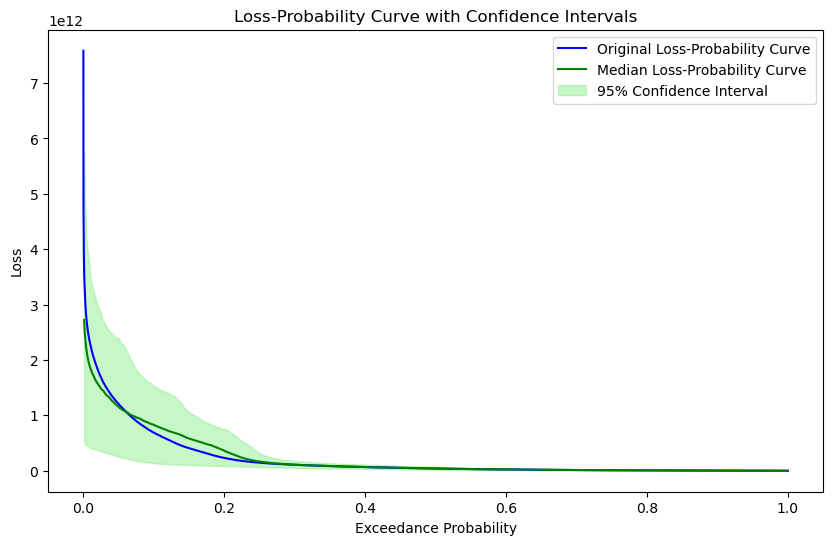

In [68]:
# Generate exceedance probabilities for each year (to match n_years length)
exceedance_probs_per_year = np.arange(1, n_years + 1) / (n_years + 1)

# Plotting
plt.figure(figsize=(10, 6))

# Use full exceedance probabilities for the original loss list
plt.plot(exceedance_probs, sorted_losses, label='Original Loss-Probability Curve', color='blue')

# Use the shortened exceedance probabilities for median losses and confidence intervals
plt.plot(exceedance_probs_per_year, median_losses, label='Median Loss-Probability Curve', color='green')
plt.fill_between(exceedance_probs_per_year, ci_lower, ci_upper, color='lightgreen', alpha=0.5, label='95% Confidence Interval')

plt.xlabel('Exceedance Probability')
plt.ylabel('Loss')
plt.title('Loss-Probability Curve with Confidence Intervals')
plt.legend()
# plt.yscale('log')  # Use log scale if losses span several orders of magnitude
plt.show()

In [72]:
# Step 1: Calculate the exceedance probability loss you want to extract
RP_loss = 100
aep_loss = 1/RP

# Step 2: Find the index corresponding to the 100-year exceedance probability
index_loss_year = int(n_years * aep_loss)

# Extract the losses corresponding to the 100-year return period across all simulations
rp_losses = sorted_losses_per_simulation[:, index_loss_year]

# Compute the median and confidence intervals
median_rp_loss = np.median(rp_losses)
ci_lower_rp_loss = np.percentile(rp_losses, 2.5)
ci_upper_rp_loss = np.percentile(rp_losses, 97.5)

# Display the results
print(f"100-Year RP Loss: {median_rp_loss:.2e}")
print(f"95% Confidence Interval: [{ci_lower_rp_loss:.2e}, {ci_upper_rp_loss:.2e}]")

100-Year RP Loss: 2.48e+12
95% Confidence Interval: [4.97e+11, 4.94e+12]


### Step 5: Quantify Uncertainty

#### 5.1 Bootstrap simulated losses

In [188]:
n = len(loss_list)
n_bootstrap_samples = 10000
bootstrapped_losses = []

for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(loss_list, size=n, replace=True)
    sorted_bootstrap_sample = np.sort(bootstrap_sample)[::-1]
    bootstrapped_losses.append(sorted_bootstrap_sample)

# Convert to numpy array
bootstrapped_losses = np.array(bootstrapped_losses)

# Calculate statistics
median_losses = np.median(bootstrapped_losses, axis=0)
ci_lower = np.percentile(bootstrapped_losses, 2.5, axis=0)
ci_upper = np.percentile(bootstrapped_losses, 97.5, axis=0)

#### 5.2 Plot curves and uncertainty

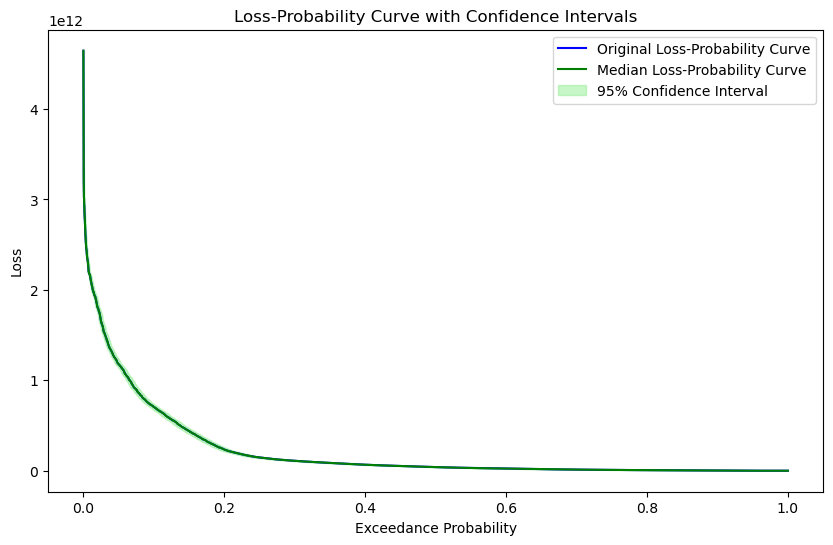

In [189]:
# Plotting
exceedance_probs = np.arange(1, n+1) / (n+1)
plt.figure(figsize=(10, 6))
plt.plot(exceedance_probs, np.sort(loss_list)[::-1], label='Original Loss-Probability Curve', color='blue')
plt.plot(exceedance_probs, median_losses, label='Median Loss-Probability Curve', color='green')
plt.fill_between(exceedance_probs, ci_lower, ci_upper, color='lightgreen', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('Exceedance Probability')
plt.ylabel('Loss')
plt.title('Loss-Probability Curve with Confidence Intervals')
plt.legend()
# plt.yscale('log')  # If the loss range is wide, a log scale may be useful
# plt.xscale('log')
plt.show()

#### 5.3 Extract Loss Information

In [190]:
# Step 1: Calculate the 100-year exceedance probability
aep_100_year = 0.01

# Step 2: Find the index corresponding to the 100-year exceedance probability
index_100_year = np.argmin(np.abs(exceedance_probs - aep_100_year))

# Step 3: Extract the 100-year losses and uncertainty bounds
loss_100_year = np.median(bootstrapped_losses[:, index_100_year])
ci_lower_100_year = np.percentile(bootstrapped_losses[:, index_100_year], 2.5)
ci_upper_100_year = np.percentile(bootstrapped_losses[:, index_100_year], 97.5)

# Print the results
print(f"100-Year Loss: {loss_100_year}")
print(f"95% Confidence Interval: ({ci_lower_100_year}, {ci_upper_100_year})")

100-Year Loss: 2133306142155.1194
95% Confidence Interval: (2047951920921.3364, 2182317709656.4146)


### TESTING AREA

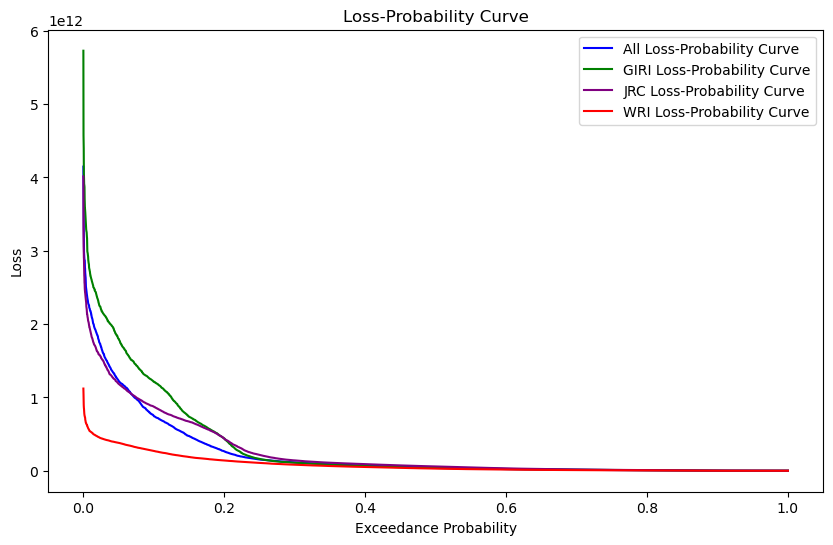

In [20]:
all_losses = all_loss_df.values.flatten().tolist()
giri_losses = giri_loss_df.values.flatten().tolist()
jrc_losses = jrc_loss_df.values.flatten().tolist()
wri_losses = wri_loss_df.values.flatten().tolist()
n = len(all_losses)
exceedance_probs = np.arange(1, n+1) / (n+1)
plt.figure(figsize=(10, 6))
plt.plot(exceedance_probs, np.sort(all_losses)[::-1], label='All Loss-Probability Curve', color='blue')
plt.plot(exceedance_probs, np.sort(giri_losses)[::-1], label='GIRI Loss-Probability Curve', color='green')
plt.plot(exceedance_probs, np.sort(jrc_losses)[::-1], label='JRC Loss-Probability Curve', color='purple')
plt.plot(exceedance_probs, np.sort(wri_losses)[::-1], label='WRI Loss-Probability Curve', color='red')
plt.xlabel('Exceedance Probability')
plt.ylabel('Loss')
plt.title('Loss-Probability Curve')
plt.legend()
# plt.yscale('log')  # If the loss range is wide, a log scale may be useful
# plt.xscale('log')
plt.show()